# Make Volumetric Graphs of Pattern Evolution

In [18]:
colors_base = {
"00":"c64_black",  
"01":"c64_white",  
"02":"c64_red",    
"03":"c64_cyan",   
"04":"c64_purple", 
"05":"c64_green",  
"06":"c64_blue",   
"07":"c64_yellow", 
"08":"c64_orange", 
"09":"c64_brown",  
"0a":"c64_ltred",  
"0b":"c64_gray1",  
"0c":"c64_lightgray",  
"0d":"c64_ltgreen",
"0e":"c64_ltblue", 
"0f":"c64_gray3",  
}
colors = [v for k,v in colors_base.items()]
    
c64_to_rgb = {
"c64_black": "#000000",     
"c64_white": "#ffffff",     
"c64_red": "#880000",       
"c64_cyan":  "#aaffee",     
"c64_purple": "#cc44cc",    
"c64_green": "#00cc55",     
#"c64_blue":  "#0000aa",     
"c64_blue":  "#0088ff",     
"c64_yellow":  "#eeee77",   
"c64_orange":  "#dd8855",   
"c64_brown": "#664400",     
"c64_ltred": "#ff7777",  
"c64_gray1":  "#333333",    
"c64_ltgreen": "#aaff66",
"c64_ltblue":  "#0088ff",
"c64_lightgrey": "#bbbbbb", 
"c64_lightgray": "#bbbbbb", 
"c64_gray3": "#bbbbbb",                             
}


Run the following command:
```sh
~/Dev/vice-emu-code/vice/src/x64sc -directory ~/Dev/vice-emu-code/vice/data/ -moncommands painttrace.txt bin/psychedelia.prg 
```
Where `painttrace.txt` is:

```
log on
logname "Batalyx-PsychedeliaIndividualPatterns.txt"
tr exec 0973
command 1 "mem d800 daf8"
```

Read in the ram history.

In [24]:
log_file = "Batalyx-PsychedeliaIndividualPatterns.txt"
input_file = open(log_file,'r')

ram_history = []
lines = input_file.readlines()
c = 0
for i in range(5, len(lines), 51):
    raw_ram = [l[9:60].split() for l in lines[i:i+48]]
    raw_ram = [int(v,16) & 0x0f for l in raw_ram for v in l]
    raw_ram = [1 if v == 0x0b else v for v in raw_ram]
    color_ram = list(reversed([raw_ram[v:v+40] for v in range(0, len(raw_ram), 40)]))[2:]
    ram_history += [color_ram]
    c += 1


Slice up the ram history into the different patterns.

In [25]:
flatten = lambda l: [e for sublist in l for e in sublist]

pattern_breaks = []
for i,h in enumerate(ram_history):
    num_pixels = sum(flatten(h))
    if num_pixels > 1:
        continue
    pattern_breaks += [i]
pattern_breaks += [i]

patterns = []
pp = 0
for p in pattern_breaks:
    patterns += [ram_history[pp:p]]
    pp = p


Methods for culling the pixel data to just the volume that's occupied.

In [28]:
def firstNonZero(l):
    for i,e in enumerate(l):
        if e > 0:
            return i
    return i

def getLeftMostPixelForPattern(pattern):
    return min([firstNonZero(r) for scr in pattern for r in scr])

def getRightMostPixelForPattern(pattern):
    return len(pattern[0][0]) - min([firstNonZero(list(reversed(r)))
                     for scr in pattern for r in scr])

def rotatePatternToCols(pattern):
    pattern_cols = []
    for scr in pattern:
        col_arr = [[0 for i in range(len(scr))] for j in range(len(scr[0]))]
        for i,r in enumerate(scr):
            for j,v in enumerate(r):
                col_arr[j][i] = v
        pattern_cols += [col_arr]
    return pattern_cols

def cullPattern(pattern):
    first_left = getLeftMostPixelForPattern(pattern)
    last_right = getRightMostPixelForPattern(pattern)
    width = last_right - first_left

    pattern_as_cols = rotatePatternToCols(pattern)
    first_top = getLeftMostPixelForPattern(pattern_as_cols)
    last_bottom = getRightMostPixelForPattern(pattern_as_cols)
    height = last_bottom - first_top
    
    culled = [[r[first_left:last_right] 
              for r in scr[first_top:last_bottom]]
              for scr in pattern]
    return culled

#cullPattern(patterns[0])
#patterns[0]

In [29]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LightSource

In [30]:
import numpy as np
plt.rcParams["figure.figsize"] = (80,80)
plt.rcParams['figure.dpi'] = 80

def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

def createVoxelData(screens):
    # prepare some coordinates
    width = len(screens[0][0])
    height = len (screens[0])
    x, y, z = np.indices((width,height,len(screens)))
    voxelarray = np.zeros((width,height,len(screens)), dtype=bool)
    colorarray = np.empty(voxelarray.shape, dtype=object)
    for zp,screen in enumerate(screens):
        for yp, row in enumerate(screen):
            for xp, col in enumerate(row):
                # Skip black, white and gray cells
                if col in [0,1,0x0c]:
                    continue
                cube = (x == xp) & (y == yp) & (z == zp)
                voxelarray |= cube
                color = c64_to_rgb[colors[col]]
                colorarray[cube] = color+"c0"

    # upscale the above voxel image, leaving gaps
    filled_2 = explode(voxelarray)
    ecolors_2 = explode(colorarray)

    # Shrink the gaps
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.10
    y[:, 0::2, :] += 0.10
    z[:, :, 0::2] += 0.10
    x[1::2, :, :] += 0.90
    y[:, 1::2, :] += 0.90
    z[:, :, 1::2] += 0.90

    return ((x,y,z), filled_2, ecolors_2)

In [31]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img



 Finally, write out our visualisation of each pattern evolution.

In [38]:
# Select our pattern
#screens = cullPattern(patterns[5])
import os
import gc

for i, screens in enumerate([p for p in patterns if len(p) > 1]):
    for azim in [-45,-225]:
        if os.path.isfile(f'batalyx_patterns/pattern{i}{azim}.png'):
            continue
        ((x,y,z), voxels, vcolors) = createVoxelData(screens)

        # and plot everything
        ax = plt.figure().add_subplot(projection='3d')
        ls = LightSource(45)
        ax.voxels(x,y,z,voxels, facecolors=vcolors, edgecolors=vcolors,lightsource=ls)
        ax.axis('off')
        ax.view_init(azim=azim, vertical_axis='y')
        img = fig2img(plt.gcf())
        im1 = None
        if azim == -45:
            im1 = img.crop((img.width/3, img.height/3, 
                            (img.width/4) * 3.3, (img.height/3) * 2.3))
        else:
            OFFSET = 150
            im1 = img.crop(((img.width/4) - OFFSET, (img.height/4) - OFFSET,
                            ((img.width/4) * 3.3) - OFFSET, ((img.height/3) * 2.3) - OFFSET))
        
        newImage = []
        for item in im1.getdata():
            if item[:3] == (255, 255, 255):
                newImage.append((255, 255, 255, 0))
            else:
                newImage.append(item)

        im1.putdata(newImage)
        im1.save(f'batalyx_patterns/pattern{i}{azim}.png')
        plt.clf()
        del voxels, vcolors
        plt.close()
        gc.collect()


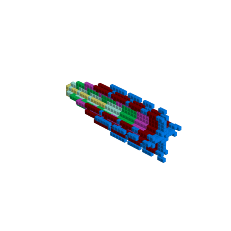

In [9]:
# Experiment with angles.

# Select our pattern
#screens = cullPattern(patterns[5])
screens = patterns[0]
((x,y,z), voxels, vcolors) = createVoxelData(screens)
ax = plt.figure().add_subplot(projection='3d')
ls = LightSource(45)
ax.voxels(x,y,z,voxels, facecolors=vcolors, edgecolors=vcolors,lightsource=ls)
ax.view_init(azim=-45, vertical_axis='y')
# Hide grid lines
ax.axis('off')
plt.show()